In [1]:
import numpy as np
import pandas as pd
import json
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
%matplotlib inline
from sklearn.model_selection import train_test_split
from ast import literal_eval

In [2]:
#load data
df = pd.read_csv('movies_metadata.csv')

C:\Users\rkies\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


For this assignment, I will use the movies dataset from Kaggle (available [here](https://www.kaggle.com/rounakbanik/the-movies-dataset)) to identify similar movies based on movie characteristics. I will start by looking at the first few rows of data and checking for missing values.

In [3]:
#look at first few rows of data
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
#get datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

In [5]:
#check for missing values
df.isnull().sum()*100/df.isnull().count()

adult                     0.000000
belongs_to_collection    90.115691
budget                    0.000000
genres                    0.000000
homepage                 82.883913
id                        0.000000
imdb_id                   0.037391
original_language         0.024194
original_title            0.000000
overview                  2.098271
popularity                0.010997
poster_path               0.848986
production_companies      0.006598
production_countries      0.006598
release_date              0.191352
revenue                   0.013197
runtime                   0.578454
spoken_languages          0.013197
status                    0.191352
tagline                  55.104914
title                     0.013197
video                     0.013197
vote_average              0.013197
vote_count                0.013197
dtype: float64

Based on the first few rows of data, the "adult" variable appears to be Boolean, but it is in fact a string variable. For using in clustering, I will change it to Boolean.

In [6]:
#change adult variable to Boolean
df['adult'] = df['adult'] == 'True'

The variables belong to collection, homepage, and tagline are missing values for more than half of the data. I will change these variables to Boolean.

In [7]:
#change variables to Boolean
cols = ['belongs_to_collection', 'homepage', 'tagline']

for col in cols:
    df[col] = df[col].isnull()

Popularity and budget are two variables that we would expect to be numeric, but are instead objects. Based on further exploration, this is because of a few anomalous values for each of the variables. We will replace those values with "None" and then convert the rest of the values to float.

In [8]:
cols = ['popularity', 'budget']

for col in cols:
    df[col] = df[col].replace('Beware Of Frost Bites', None)
    df[col] = df[col].replace('/ff9qCepilowshEtG2GYWwzt2bs4.jpg', None)
    df[col] = df[col].replace('/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg', None)
    df[col] = df[col].replace('/zaSf5OG7V8X8gqFvly88zDdRm46.jpg', None)
    df[col] = df[col].apply(lambda x: float(x))

For the columns with numeric values, I will fill the missing values with the mean. Since no column is missing more than 3% of the data, I will then go ahead and drop the missing values for the rest of the columns.

In [9]:
cols = ['popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
for col in cols:
    df[col] = df[col].fillna(df[col].mean())

In [10]:
df = df.dropna()

Next, I will work with production companies, production countries, and genres. First, I will get the data into a format that is easier to work with.

In [11]:
df['production_companies'] = df['production_companies'].apply(literal_eval)
df['production_countries'] = df['production_countries'].apply(literal_eval)
df['genres'] = df['genres'].apply(literal_eval)

In [12]:
#get list of names for variable
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        return names
    #Return empty list in case of missing/malformed data
    return []

In [13]:
#get list for genres, production companies, production countries
df['genres'] = df['genres'].apply(get_list)
df['production_companies'] = df['production_companies'].apply(get_list)
df['production_countries'] = df['production_countries'].apply(get_list)

Next, I will create dummy variables for each of the genres. There are a few anomalous values for genre that I will not create dummy variables for.

In [14]:
genres = ['Music', 'Animation', 'Comedy', 'Adventure', 'Romance', 'Drama', 'Family', 'Fantasy', 'Crime', 'Action', 'Mystery',
         'Thriller', 'Horror', 'History', 'Science Fiction', 'War', 'Foreign', 'Documentary', 'Western', 'TV Movie']
#get dummy variables for genre
genre_columns = pd.get_dummies(df['genres'].apply(pd.Series).stack()).sum(level=0)
genre_column_names = []
#concat genre variables with rest of data
for genre in genres:
    df = pd.concat([df, genre_columns[genre]], axis=1)
    genre_column_names.append(genre)

For production countries and production companies, I do not want to create dummy variables for all of the values because there are so many of them. I will first look at the most common values for each of those variables, and then create dummy variables for just the most common values.

In [15]:
#define function to count items in a column list
def list_counter(col):
    result = dict()
    for cell in col:
        if isinstance(cell, float):
            continue
        for word in cell:
            if word in result:
                result[word] += 1
            else:
                result[word] = 1
    result = {k: v for k, v in sorted(result.items(), key=lambda item: item[1], reverse=True)}
    sum_selected = 0
    total_selected = 0
    rest = 0
    returned = []
    for i in result: 
        sum_selected += result[i]
        total_selected += result[i]
        returned.append([i, result[i]])
    return returned

In [16]:
#create a data frame with counts for each production country
countries_occur = list_counter(df["production_countries"].values)
countries = pd.DataFrame.from_records(countries_occur, columns=["production_countries", "count"])
#get number of countries
print(len(countries))
#select countries that produced at least 400 films
countries[countries['count'] >= 400]

160


,production_countries,count
0,United States of America,21018
1,United Kingdom,4069
2,France,3802
3,Germany,2151
4,Italy,1980
5,Canada,1744
6,Japan,1638
7,Spain,917
8,Russia,883
9,India,820


For production countries, I will include dummy variables for any country that produced at least 400 variables.

In [17]:
top_countries = ['United States of America', 'United Kingdom', 'France', 'Germany', 'Italy', 'Canada', 'Japan', 'Spain',
                 'Russia', 'India', 'Hong Kong', 'Sweden', 'Australia', 'South Korea', 'Belgium']
#create dummy variables for production countries
country_columns = pd.get_dummies(df['production_countries'].apply(pd.Series).stack()).sum(level=0)
country_column_names = []
#append dummy variables for the top countries to rest of data
for country in top_countries:
    df = pd.concat([df, country_columns[country]], axis=1)
    country_column_names.append(country)

In [18]:
#get counts for each production company
companies_occur = list_counter(df["production_companies"].values)
companies = pd.DataFrame.from_records(companies_occur, columns=["production_companies", "count"])
#print number of companies
print(len(companies))
#select companies that have produced at least 200 films
companies[companies['count'] > 200]

23280


,production_companies,count
0,Warner Bros.,1244
1,Metro-Goldwyn-Mayer (MGM),1075
2,Paramount Pictures,1002
3,Twentieth Century Fox Film Corporation,836
4,Universal Pictures,830
5,Columbia Pictures Corporation,448
6,Columbia Pictures,431
7,Canal+,428
8,RKO Radio Pictures,290
9,United Artists,279


Since there is a wider variety of production companies, I will include dummy variables for any company that produced at least 200 films.

In [19]:
companies = ['Warner Bros.', 'Metro-Goldwyn-Mayer (MGM)', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation',
            'Universal Pictures', 'Columbia Pictures Corporation', 'Columbia Pictures', 'RKO Radio Pictures', 'Canal+',
            'United Artists', 'New Line Cinema', 'Walt Disney Pictures', 'Touchstone Pictures']
#get dummy variables for production companies
company_columns = pd.get_dummies(df['production_companies'].apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)
company_column_names = []
#append dummy variables for most common production companies to rest of data
for company in companies:
    df = pd.concat([df, company_columns[company]], axis=1)
    company_column_names.append(company)

Next, I will apply a similar process to create dummy variables for original language. This process is slightly different because there is only a single value for original language for each film.

In [20]:
languages_occur = df['original_language'].value_counts()
languages = languages_occur.rename_axis('original_language').reset_index(name='count')
print(len(languages))
languages[languages['count'] > 400]

89


,original_language,count
0,en,31791
1,fr,2273
2,ja,1343
3,it,1264
4,de,959
5,es,923
6,ru,782
7,hi,506
8,ko,444
9,zh,406


Like production country, I will include dummy variables for any language that appeared in at least 400 films.

In [21]:
top_languages = ['en', 'fr', 'ja', 'it', 'de', 'es', 'ru', 'hi', 'ko', 'zh']
#get dummy variables for languages
language_columns = pd.get_dummies(df['original_language'], prefix = 'language')
language_column_names = []
#add columns for most popular languages to main df
for lang in top_languages:
    df = pd.concat([df, language_columns['language_' + lang]], axis=1)
    language_column_names.append('language_' + lang)

Next, I will look at the status column.

In [22]:
#get counts for each status
status_occur = df['status'].value_counts()
statuses = status_occur.rename_axis('status').reset_index(name='count')
print(len(statuses))
statuses

6


,status,count
0,Released,43709
1,Rumored,214
2,Post Production,96
3,In Production,16
4,Planned,12
5,Canceled,1


For our purposes, we will only look at the films that have been released, as information for films that have not been released may not be entirely accurate.

In [23]:
df = df[df['status'] == 'Released']

Information about the cast and crew of each film is also available in a separate csv.

In [24]:
#load cast and crew info
credits_df = pd.read_csv('credits.csv')
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [25]:
#convert features to dictionary
features = ['cast', 'crew']
for feature in features:
    credits_df[feature] = credits_df[feature].apply(literal_eval)

Next, I will select the director for each film from the crew column and store it in its own column. Then I will look at the most popular directors and create dummy variables for those directors.

In [26]:
#define function to select director
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [27]:
#create new director column
credits_df['director'] = credits_df['crew'].apply(get_director)

In [28]:
#get counts for each director
directors_occur = credits_df['director'].value_counts()
directors = directors_occur.rename_axis('director').reset_index(name='count')
#select number of directors
print(len(directors))
#select directors who have made at least 40 films
directors[directors['count'] >= 40]

17572


,director,count
0,John Ford,66
1,Michael Curtiz,65
2,Werner Herzog,54
3,Alfred Hitchcock,53
4,Georges Méliès,51
5,Woody Allen,49
6,Jean-Luc Godard,47
7,Sidney Lumet,46
8,Charlie Chaplin,44
9,Raoul Walsh,43


I will add dummy variables to the data frame for each director who made at least 40 films.

In [29]:
top_directors = ['John Ford', 'Michael Curtiz', 'Werner Herzog', 'Alfred Hitchcock', 'Georges Méliès', 'Woody Allen', 
                'Jean-Luc Godard', 'Sidney Lumet', 'Charlie Chaplin', 'Raoul Walsh', 'Henry Hathaway', 
                 'William A. Wellman', 'Martin Scorsese', 'Richard Thorpe']
#get dummy variables for the directors
director_columns = pd.get_dummies(credits_df['director'])
director_column_names = []
#concat top director dummy columns with the credits data frame
for dir in top_directors:
    credits_df = pd.concat([credits_df, director_columns[dir]], axis=1)
    director_column_names.append(dir)

I will convert the cast column to a list to make it easier to work with.

In [30]:
#convert cast to list
credits_df['cast'] = credits_df['cast'].apply(get_list)

Next, I will get keyword information from the keywords csv.

In [31]:
keywords_df = pd.read_csv('keywords.csv')
keywords_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


I will convert the keywords column into a list so that it is easier to work with. Then, I will look at the most common keywords and create variables for those, as I have done several times.

In [32]:
#convert keywords to list
keywords_df['keywords'] = keywords_df['keywords'].apply(literal_eval)
keywords_df['keywords'] = keywords_df['keywords'].apply(get_list)

In [33]:
#get counts of each keyword
keyword_occur = list_counter(keywords_df["keywords"].values)
keywords = pd.DataFrame.from_records(keyword_occur, columns=["keyword", "count"])
#select number of keywords
print(len(keywords))
#select keywords that describe at least 400 films
keywords[keywords['count'] >= 400]

19956


,keyword,count
0,woman director,3115
1,independent film,1930
2,murder,1308
3,based on novel,835
4,musical,734
5,sex,685
6,violence,651
7,nudity,636
8,biography,629
9,revenge,626


I will include dummy variables for keywords that describe at least 400 films.

In [34]:
top_keywords = ['woman director', 'independent film', 'murder', 'based on novel', 'musical', 'sex', 'violence', 'nudity', 
               'biography', 'revenge', 'suspense', 'love', 'female nudity', 'sport', 'police', 'teenager', 
                'duringcreditsstinger', 'sequel', 'friendship']
#get dummy variables for keywords
keyword_columns = pd.get_dummies(keywords_df['keywords'].apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)
keyword_column_names = []
#append dummy variables for most common keywords to credits dataframe
for word in top_keywords:
    keywords_df = pd.concat([keywords_df, keyword_columns[word]], axis=1)
    keyword_column_names.append(word)

Since the id variable in the credits and keywords dataframe is numeric, I must convert the id variable in the main dataframe to numeric before I merge the dataframes. I will merge both of the dataframes with the main dataframe.

In [35]:
#convert id column to numeric
df['id'] = df['id'].apply(lambda x: int(x))
#merge credits df with main df
df = df.merge(credits_df ,on='id')
#merge keywords df with main df
df = df.merge(keywords_df ,on='id')

I will check for missing values again to see if any of the data manipulation has introduced any missing values.

In [36]:
#get percentages of missing values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending = False)
missing_value_df[missing_value_df['percent_missing'] > 0]

,column_name,percent_missing
Spain,Spain,13.015533
United States of America,United States of America,13.015533
Russia,Russia,13.015533
Hong Kong,Hong Kong,13.015533
Sweden,Sweden,13.015533
Australia,Australia,13.015533
South Korea,South Korea,13.015533
Belgium,Belgium,13.015533
India,India,13.015533
United Kingdom,United Kingdom,13.015533


For dummy variables that are missing values, I will replace the null values with 0.

In [37]:
cols = ['Spain', 'United States of America', 'Russia', 'Hong Kong', 'Sweden', 'Australia', 'South Korea', 'Belgium',
        'India', 'United Kingdom', 'Japan', 'Canada', 'Italy', 'Germany', 'France', 'Horror', 'Crime', 
        'Action', 'Mystery', 'Thriller', 'TV Movie', 'History', 'Science Fiction', 'Foreign', 'Documentary', 'Western', 
        'Family', 'Fantasy', 'War', 'Drama', 'Music', 'Adventure', 'Romance', 'Comedy', 'Animation']
for col in cols:
    df[col] = df[col].fillna(0)

Next, I will look more closely at the numeric variables by plotting their histograms.

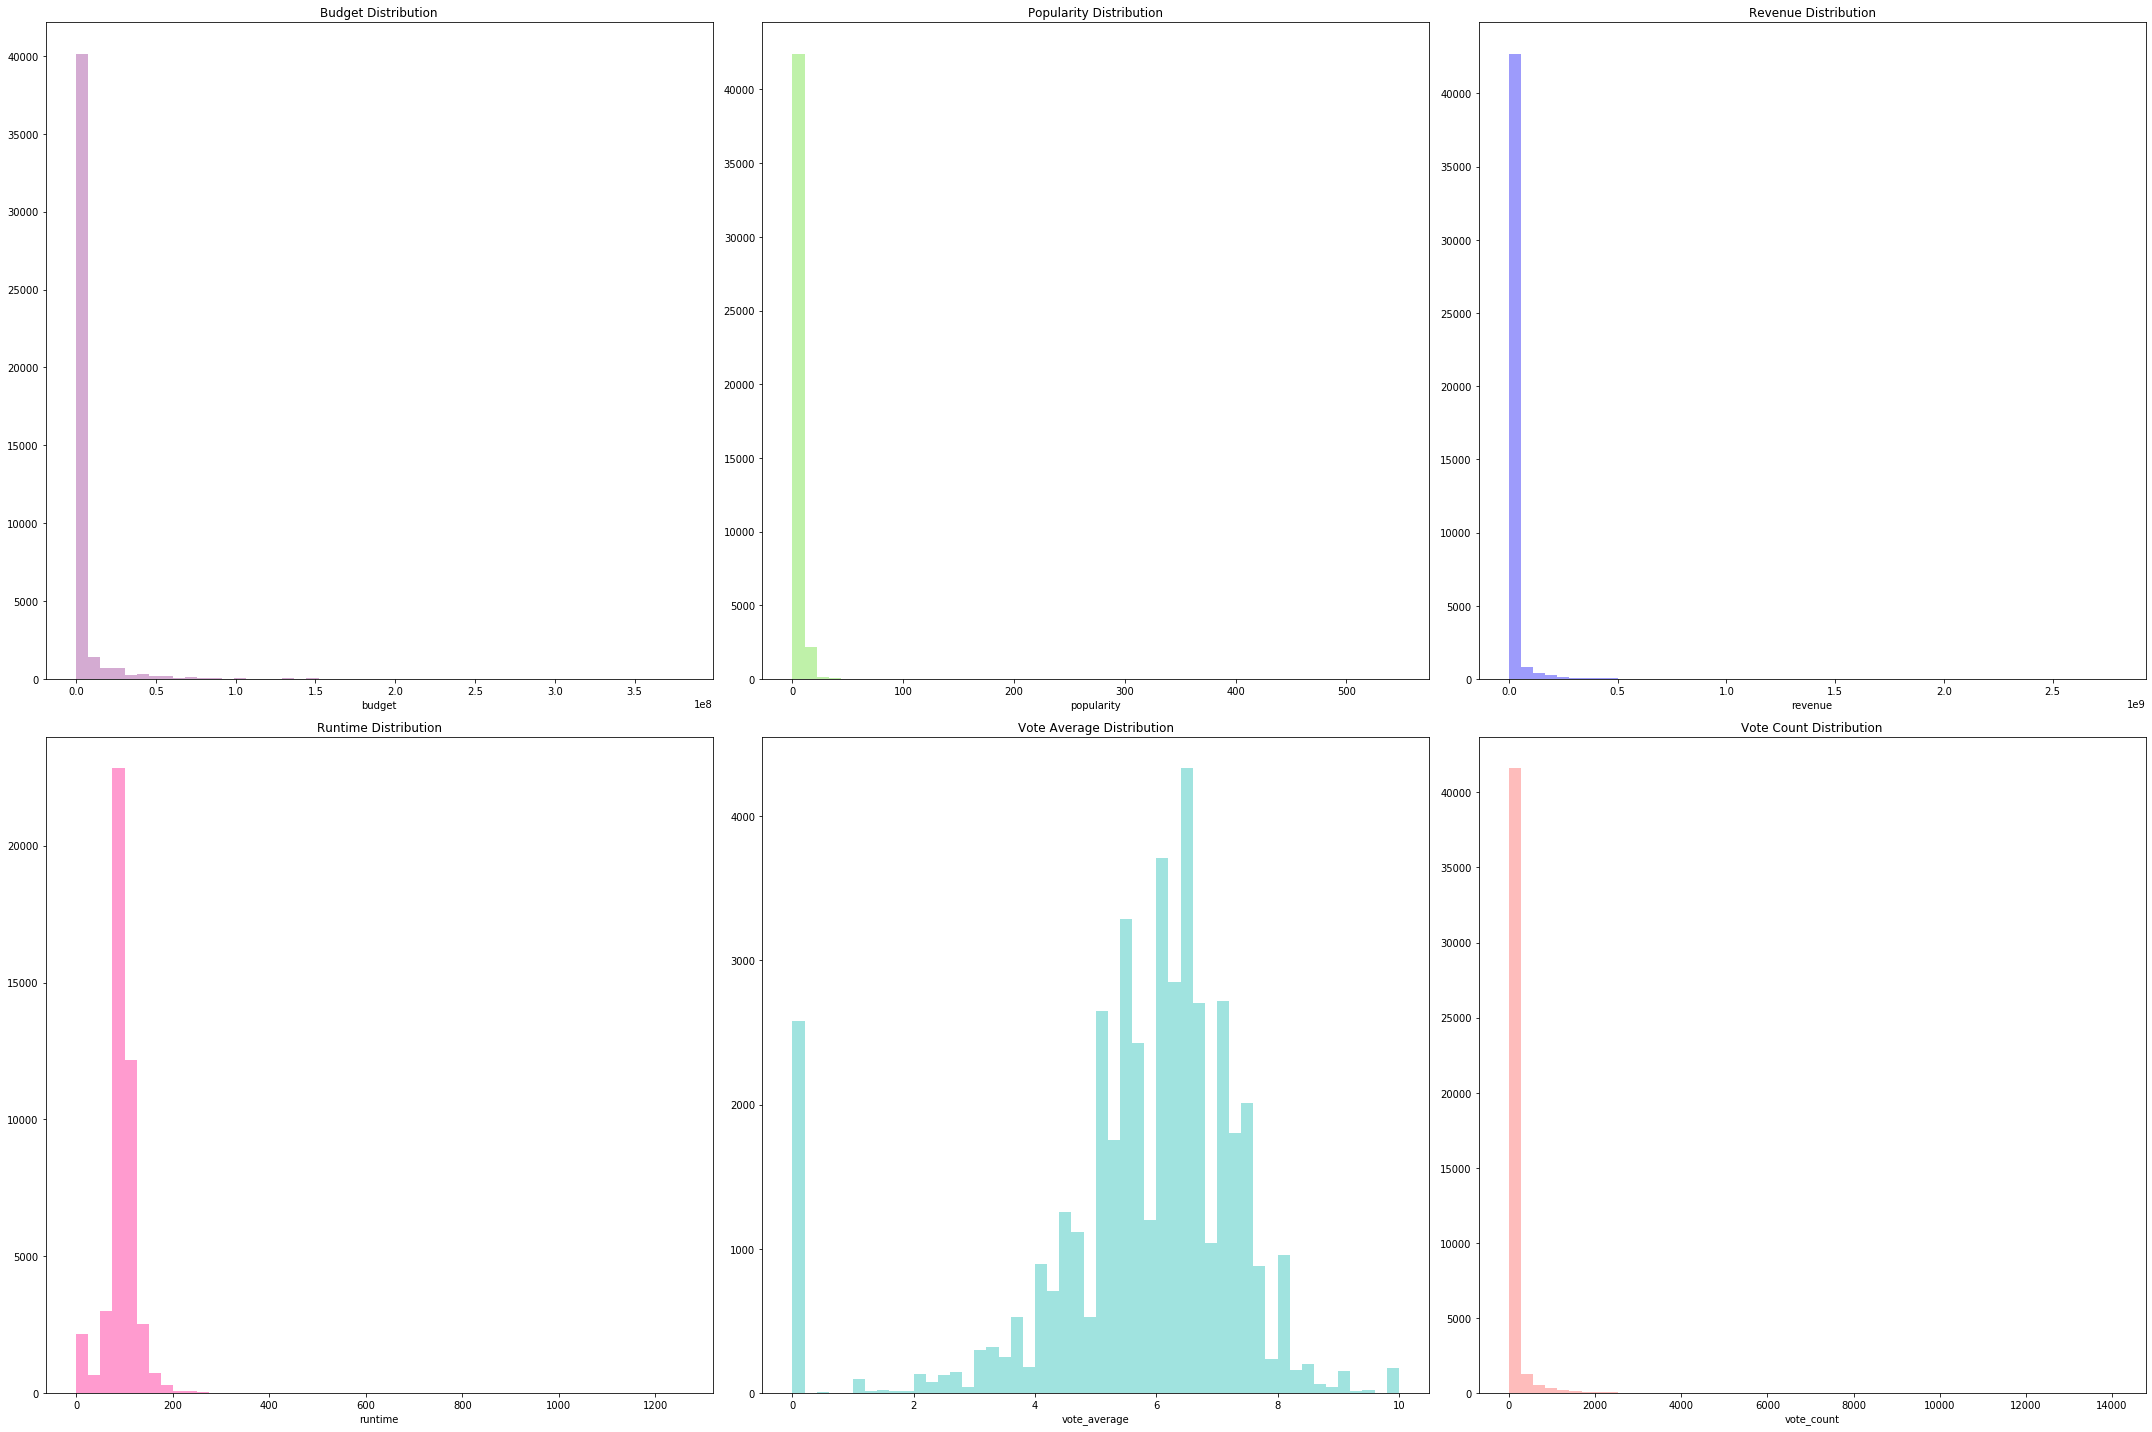

In [38]:
#plot histograms of numeric variables
plt.figure(figsize = (30, 20))
plt.subplot(2, 3, 1)
sns.distplot(df['budget'], kde = False, color = '#952e8f')
plt.title('Budget Distribution')
plt.subplot(2, 3, 2)
sns.distplot(df['popularity'], kde = False, color = '#61de2a')
plt.title('Popularity Distribution')
plt.subplot(2, 3, 3)
sns.distplot(df['revenue'], kde = False, color = '#0c06f7')
plt.title('Revenue Distribution')
plt.subplot(2, 3, 4)
sns.distplot(df['runtime'], kde = False, color = '#ff0789')
plt.title('Runtime Distribution')
plt.subplot(2, 3, 5)
sns.distplot(df['vote_average'], kde = False, color = '#13bbaf')
plt.title('Vote Average Distribution')
plt.subplot(2, 3, 6)
sns.distplot(df['vote_count'], kde = False, color = '#fd5956')
plt.title('Vote Count Distribution')
plt.tight_layout()
plt.show()

Several of the variables primarily take the value 0. To try to make our data less skewed, I will take the subset of the data where each of the numeric variables (budget, popularity, revenue, runtime, vote average, and vote count) is not 0.

In [39]:
df = df[df['budget'] != 0]
df = df[df['revenue'] != 0]
df = df[df['popularity'] != 0]
df = df[df['runtime'] != 0]
df = df[df['vote_average'] != 0]
df = df[df['vote_count'] != 0]

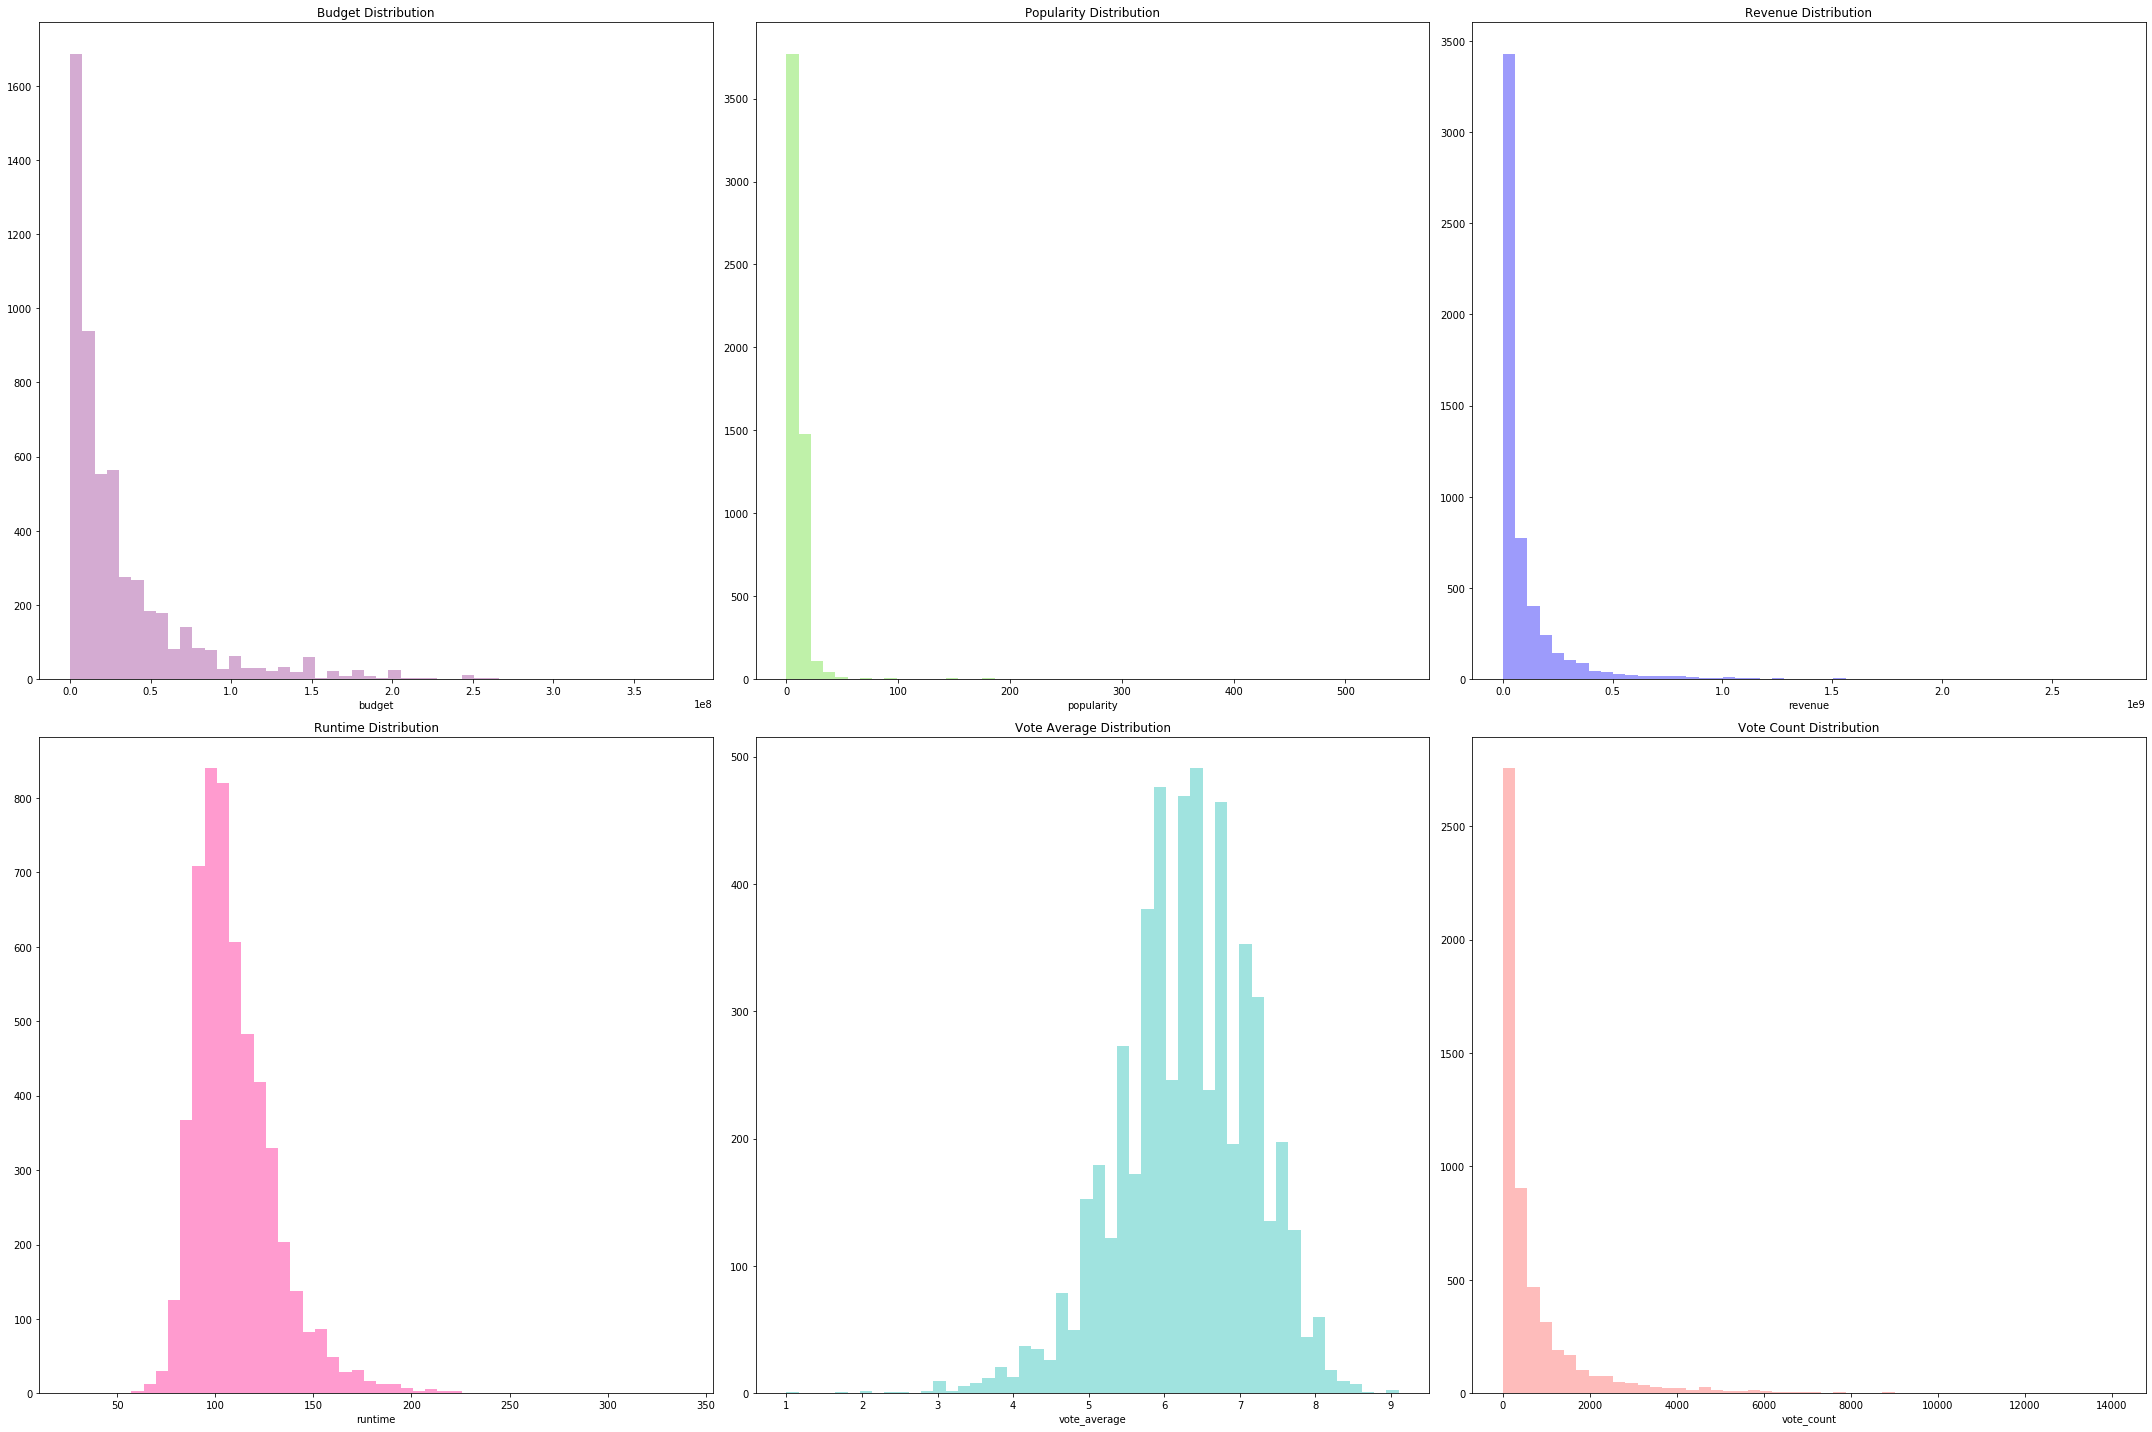

In [40]:
#plot histograms of numeric variables
plt.figure(figsize = (30, 20))
plt.subplot(2, 3, 1)
sns.distplot(df['budget'], kde = False, color = '#952e8f')
plt.title('Budget Distribution')
plt.subplot(2, 3, 2)
sns.distplot(df['popularity'], kde = False, color = '#61de2a')
plt.title('Popularity Distribution')
plt.subplot(2, 3, 3)
sns.distplot(df['revenue'], kde = False, color = '#0c06f7')
plt.title('Revenue Distribution')
plt.subplot(2, 3, 4)
sns.distplot(df['runtime'], kde = False, color = '#ff0789')
plt.title('Runtime Distribution')
plt.subplot(2, 3, 5)
sns.distplot(df['vote_average'], kde = False, color = '#13bbaf')
plt.title('Vote Average Distribution')
plt.subplot(2, 3, 6)
sns.distplot(df['vote_count'], kde = False, color = '#fd5956')
plt.title('Vote Count Distribution')
plt.tight_layout()
plt.show()

In order to obtain a reasonable number of clusters, we will limit the data to the top-rated films, i.e. the films with a vote average of at least 7.5. This leaves us with 468 films to work with.

In [41]:
df = df[df['vote_average'] >= 7.5]
print('Number of films: ', len(df))

Number of films:  468


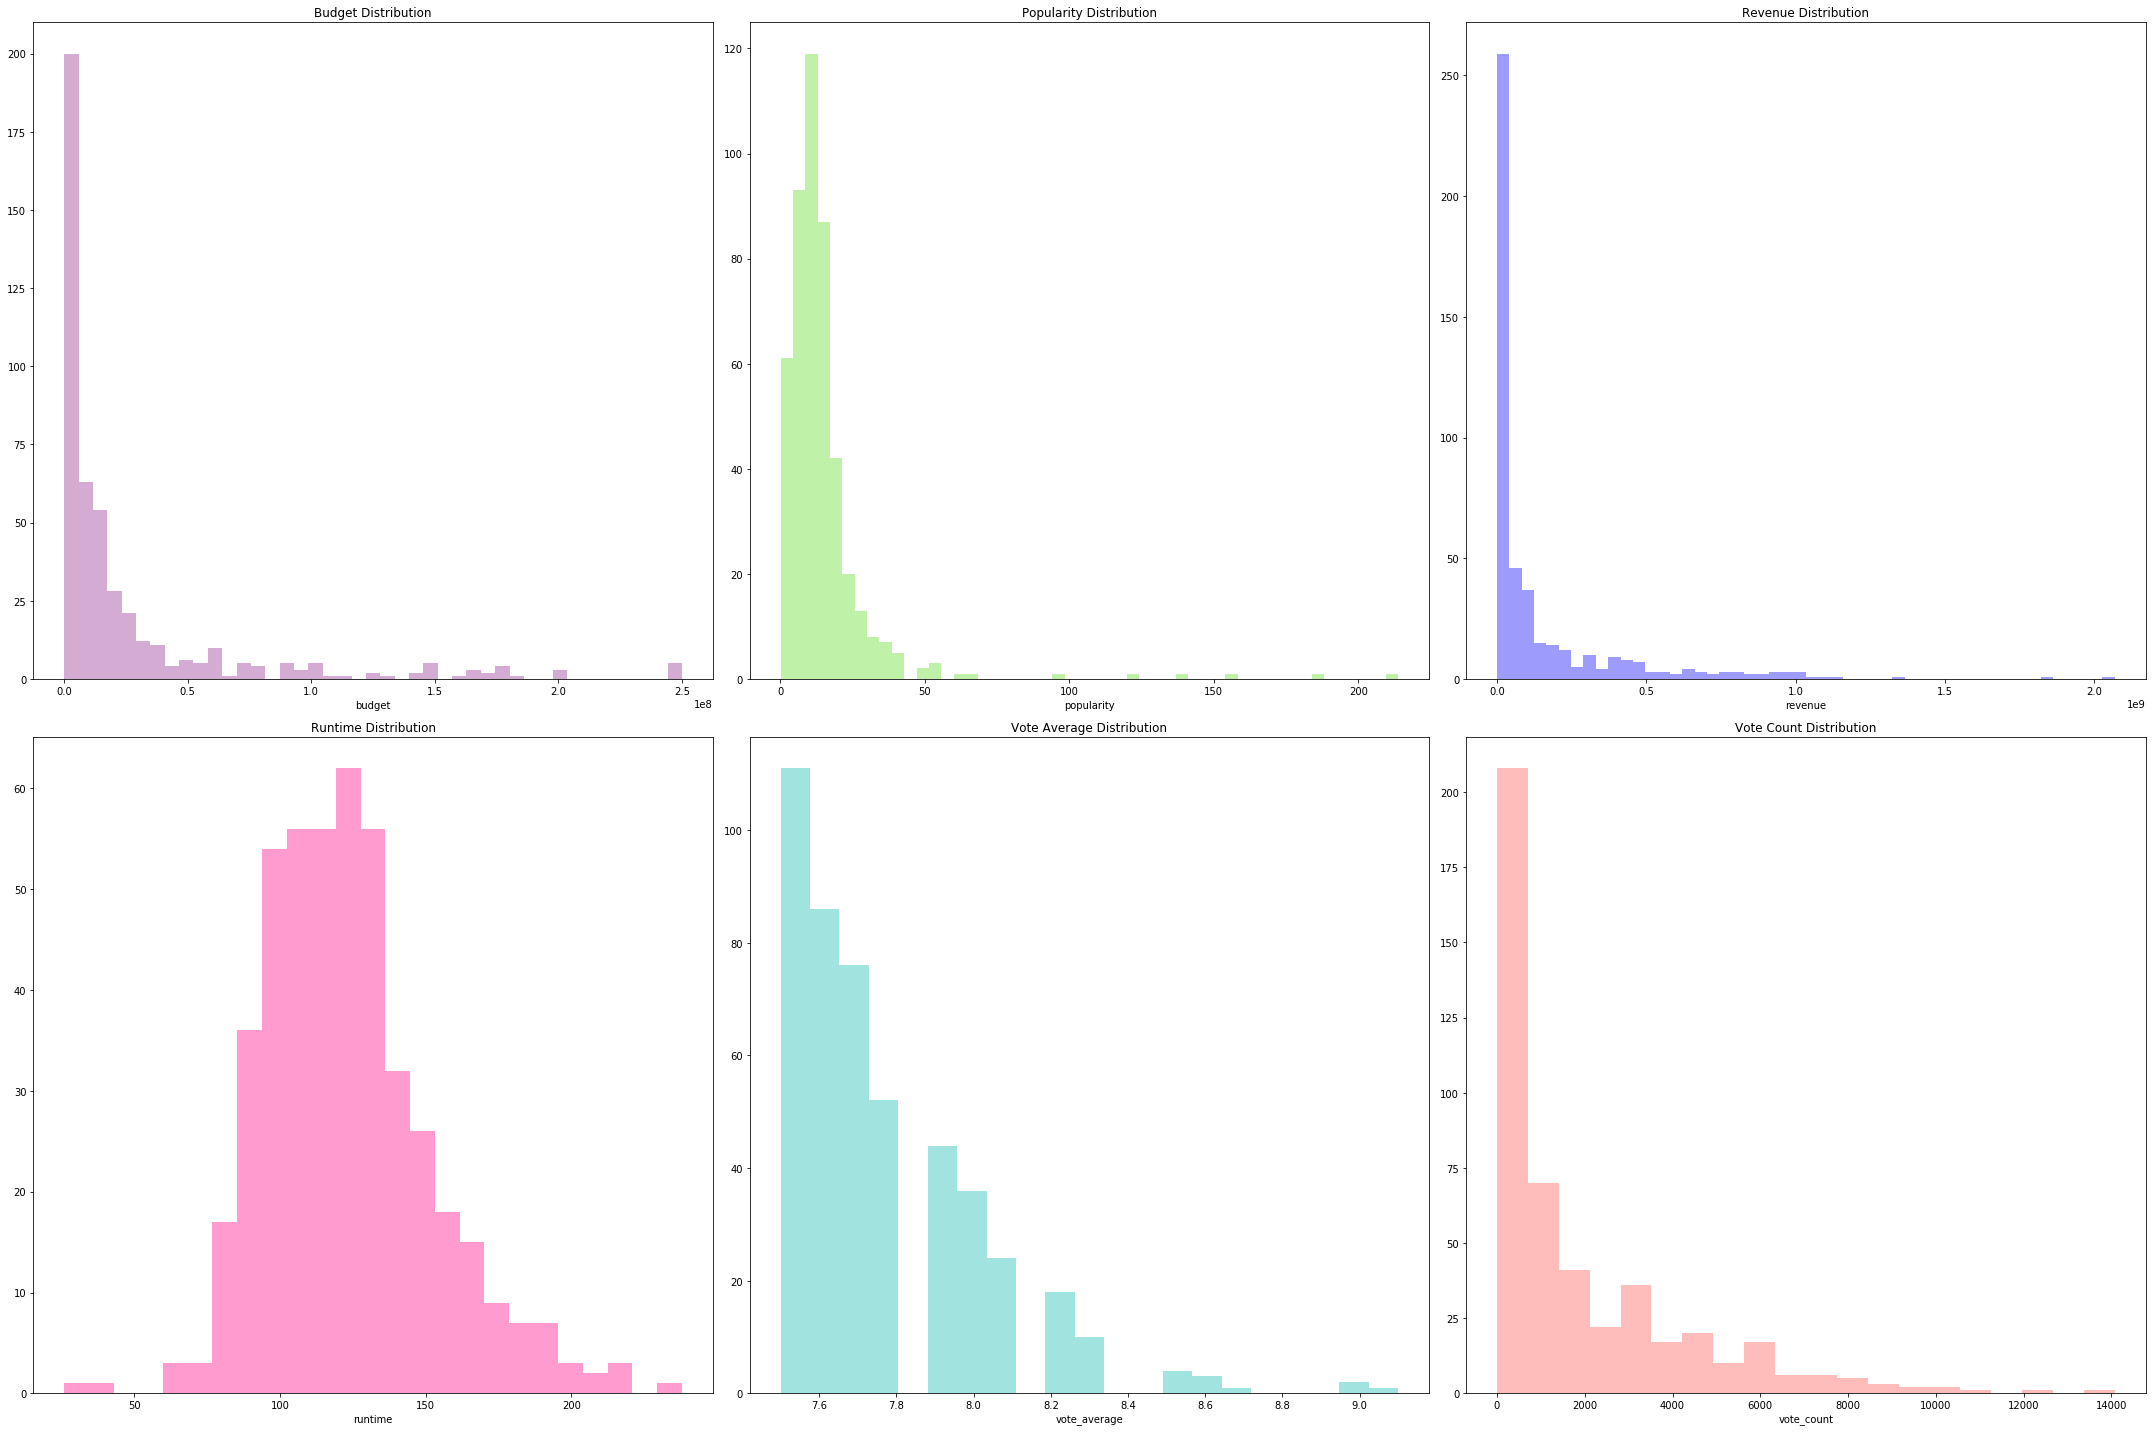

In [42]:
#plot histograms of numeric variables
plt.figure(figsize = (30, 20))
plt.subplot(2, 3, 1)
sns.distplot(df['budget'], kde = False, color = '#952e8f')
plt.title('Budget Distribution')
plt.subplot(2, 3, 2)
sns.distplot(df['popularity'], kde = False, color = '#61de2a')
plt.title('Popularity Distribution')
plt.subplot(2, 3, 3)
sns.distplot(df['revenue'], kde = False, color = '#0c06f7')
plt.title('Revenue Distribution')
plt.subplot(2, 3, 4)
sns.distplot(df['runtime'], kde = False, color = '#ff0789')
plt.title('Runtime Distribution')
plt.subplot(2, 3, 5)
sns.distplot(df['vote_average'], kde = False, color = '#13bbaf')
plt.title('Vote Average Distribution')
plt.subplot(2, 3, 6)
sns.distplot(df['vote_count'], kde = False, color = '#fd5956')
plt.title('Vote Count Distribution')
plt.tight_layout()
plt.show()

The data for budget, popularity, revenue, and vote count is very skewed. I will apply a log transformation to those variables so that their distributions are closer to normal.

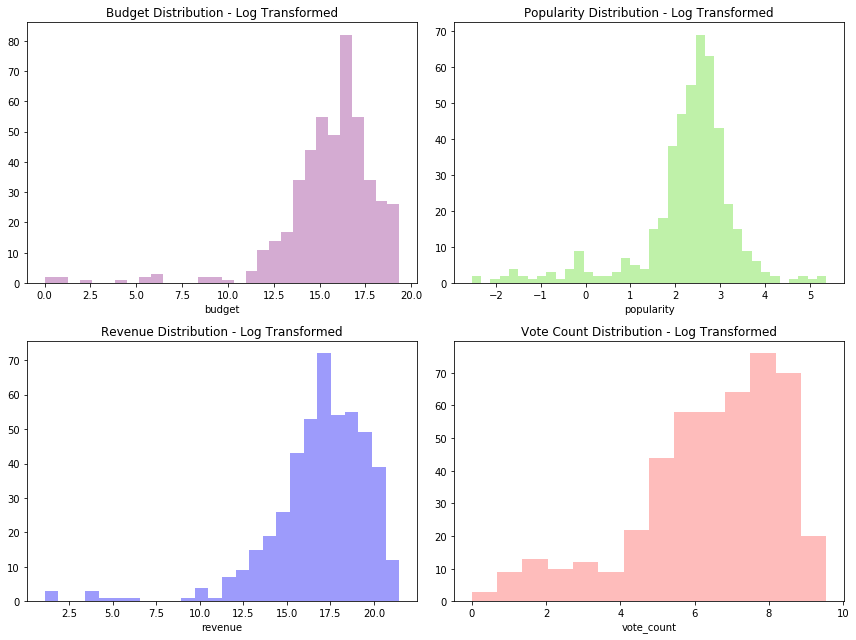

In [43]:
#plot histograms of numeric variables
plt.figure(figsize = (12, 9))
plt.subplot(2, 2, 1)
sns.distplot(np.log(df['budget']), kde = False, color = '#952e8f')
plt.title('Budget Distribution - Log Transformed')
plt.subplot(2, 2, 2)
sns.distplot(np.log(df['popularity']), kde = False, color = '#61de2a')
plt.title('Popularity Distribution - Log Transformed')
plt.subplot(2, 2, 3)
sns.distplot(np.log(df['revenue']), kde = False, color = '#0c06f7')
plt.title('Revenue Distribution - Log Transformed')
plt.subplot(2, 2, 4)
sns.distplot(np.log(df['vote_count']), kde = False, color = '#fd5956')
plt.title('Vote Count Distribution - Log Transformed')
plt.tight_layout()
plt.show()

In [44]:
df['budget_transformed'] = np.log(df['budget'])
df['popularity_transformed'] = np.log(df['popularity'])
df['revenue_transformed'] = np.log(df['revenue'])
df['vote_count_transformed'] = np.log(df['vote_count'])

Now, we will prepare the data to use in clustering.

In [45]:
#drop non-numeric variables and variables with transformed versions
X = df.drop(['budget', 'genres', 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 'popularity', 
             'production_companies', 'production_countries', 'release_date', 'revenue', 'spoken_languages',
            'status', 'title', 'video', 'vote_count', 'cast', 'crew', 'director', 'keywords'], axis = 1)

#normalize the data
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

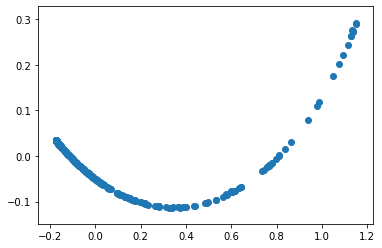

In [46]:
#visualize the pca components
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

Visually, we can see some potential clusters of data. Next, I will try a variety of different clustering algorithms to see how they categorize the data. I will start with MeanShift clustering, as it automatically determines the number of clusters.

In [47]:
#get bandwidth for model
bandwidth = estimate_bandwidth(X_norm, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 5


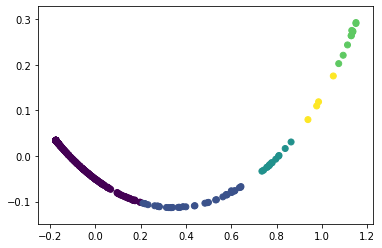

In [48]:
#plot the mean shift clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

In [49]:
#store cluster assignments in dataframe
pred = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(X_norm)
df['ms_cluster'] = pred
for i in range(0, 5):
    print('Films in cluster ' + str(i) + ' :',len(df[df['ms_cluster']== i]))

Films in cluster 0 : 401
Films in cluster 1 : 39
Films in cluster 2 : 14
Films in cluster 3 : 10
Films in cluster 4 : 4


The vast majority of the films are contained in the first cluster, which does not seem particularly helpful; however, the other clusters may do a better job of categorizing similar movies.

In [50]:
df[df['ms_cluster'] == 2]['title']

210                                        Before Sunrise
533                                          Blade Runner
1155                              Raiders of the Lost Ark
1245                   Indiana Jones and the Last Crusade
2197                                   American History X
3437                                            Gladiator
4076                                              Memento
4117                                             Scarface
4846    The Lord of the Rings: The Fellowship of the Ring
5739                                          Talk to Her
5812                The Lord of the Rings: The Two Towers
6934                   Nausicaä of the Valley of the Wind
6986        The Lord of the Rings: The Return of the King
9503                                  Million Dollar Baby
Name: title, dtype: object

In [51]:
df[df['ms_cluster'] == 3]['title']

254                                             Star Wars
348                                          Forrest Gump
891                                          Citizen Kane
1164                                       Apocalypse Now
1884                                           Metropolis
2727                                      American Beauty
3765                                   Dancer in the Dark
6228                                         Finding Nemo
6383    Pirates of the Caribbean: The Curse of the Bla...
6715                                    Kill Bill: Vol. 1
Name: title, dtype: object

In [52]:
df[df['ms_cluster'] == 4]['title']

892                     2001: A Space Odyssey
1220                               Unforgiven
4085                            Amores perros
7192    Eternal Sunshine of the Spotless Mind
Name: title, dtype: object

The films found in the last three clusters show some similarities, but not all of the commonalities between the groups are entirely clear. Cluster 4, in particular, does not seem to contain movies with much in common. 

Because most of the films were clustered together, this model is not particularly useful. I will try using K-means clustering instead. I will start with 5 clusters, the same as the MeanShift model above.

In [53]:
# Declare and fit the model.
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X_norm)

# Extract cluster assignments for each data point.
labels = kmeans.labels_

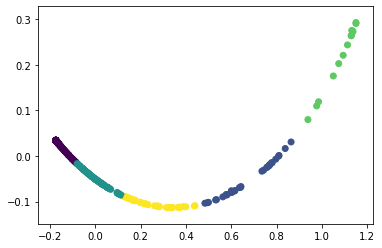

In [54]:
#plot k-means clusters visually
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

We can see from the graph that, while there are the same number of clusters, the clusters are not the same as those found using MeanShift.

In [55]:
#store cluster assignments
pred = KMeans(n_clusters = 5).fit_predict(X_norm)
df['km5_cluster'] = pred
for i in range(0, 5):
    print('Films in cluster ' + str(i) + ' :',len(df[df['km5_cluster']== i]))

Films in cluster 0 : 281
Films in cluster 1 : 31
Films in cluster 2 : 43
Films in cluster 3 : 14
Films in cluster 4 : 99


The films are more evenly distributed in this model, but the bulk of the films are still contained in a single cluster. I will try using K-means with a larger number of clusters, 10.

In [56]:
# Declare and fit the model.
kmeans = KMeans(n_clusters = 10)
kmeans.fit(X_norm)

# Extract cluster assignments for each data point.
labels = kmeans.labels_

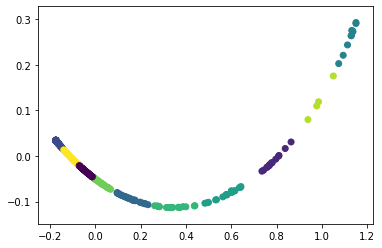

In [57]:
#plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

In [58]:
#store cluster assignments
pred = KMeans(n_clusters = 10).fit_predict(X_norm)
df['km10_cluster'] = pred
for i in range(0, 10):
    print('Films in cluster ' + str(i) + ' :',len(df[df['km10_cluster']== i]))

Films in cluster 0 : 249
Films in cluster 1 : 14
Films in cluster 2 : 33
Films in cluster 3 : 11
Films in cluster 4 : 18
Films in cluster 5 : 43
Films in cluster 6 : 39
Films in cluster 7 : 17
Films in cluster 8 : 3
Films in cluster 9 : 41


Next, I will look more closely at the clusters found using KMeans clustering with k equal to 10. Two of the clusters in this example are identical to two of the clusters found using MeanShift.

In [59]:
df[df['km10_cluster'] == 7]['title']

107                               Braveheart
108                              Taxi Driver
287                   Leon: The Professional
1167                         Wings of Desire
1177                  The Godfather: Part II
1224                      Back to the Future
1228                                   Akira
1636                        The Big Lebowski
2068                        The Untouchables
2408     Lock, Stock and Two Smoking Barrels
2869                       Princess Mononoke
3865                                  Snatch
4734                            Donnie Darko
5468                           Spirited Away
7897                           Before Sunset
10438                     Brokeback Mountain
12472                        The Dark Knight
Name: title, dtype: object

In [60]:
df[df['km10_cluster'] == 1]['title']

210                                        Before Sunrise
533                                          Blade Runner
1155                              Raiders of the Lost Ark
1245                   Indiana Jones and the Last Crusade
2197                                   American History X
3437                                            Gladiator
4076                                              Memento
4117                                             Scarface
4846    The Lord of the Rings: The Fellowship of the Ring
5739                                          Talk to Her
5812                The Lord of the Rings: The Two Towers
6934                   Nausicaä of the Valley of the Wind
6986        The Lord of the Rings: The Return of the King
9503                                  Million Dollar Baby
Name: title, dtype: object

In [61]:
df[df['km10_cluster'] ==5]['title']

5                                   Heat
28             The City of Lost Children
45                                 Se7en
48                    The Usual Suspects
753                        Trainspotting
867                  Singin' in the Rain
884                        Roman Holiday
890                     Sunset Boulevard
916                                Giant
1048                       Life of Brian
1058                             Platoon
1072            A Streetcar Named Desire
1099     Monty Python and the Holy Grail
1185                          Annie Hall
1206                           Chinatown
1221            The Manchurian Candidate
1230                      Cool Hand Luke
1235                  The Great Dictator
1564                             Gattaca
1819                   On the Waterfront
1823               A Man for All Seasons
1950                         Blue Velvet
2034                     Rosemary's Baby
2060                Strangers on a Train
2192            

Next, I will try using K-means with k = 25.

In [62]:
# Declare and fit the model.
kmeans = KMeans(n_clusters = 25)
kmeans.fit(X_norm)

# Extract cluster assignments for each data point.
labels = kmeans.labels_

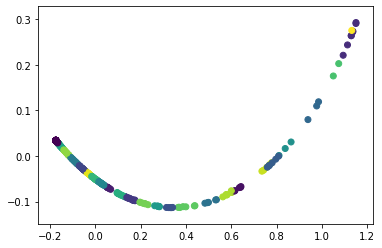

In [63]:
#plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

In [64]:
#store cluster assignments
pred = KMeans(n_clusters = 25).fit_predict(X_norm)
df['km25_cluster'] = pred
for i in range(0, 25):
    print('Films in cluster ' + str(i) + ' :',len(df[df['km25_cluster']== i]))

Films in cluster 0 : 210
Films in cluster 1 : 4
Films in cluster 2 : 3
Films in cluster 3 : 11
Films in cluster 4 : 25
Films in cluster 5 : 5
Films in cluster 6 : 3
Films in cluster 7 : 17
Films in cluster 8 : 2
Films in cluster 9 : 16
Films in cluster 10 : 26
Films in cluster 11 : 3
Films in cluster 12 : 8
Films in cluster 13 : 35
Films in cluster 14 : 5
Films in cluster 15 : 5
Films in cluster 16 : 23
Films in cluster 17 : 1
Films in cluster 18 : 5
Films in cluster 19 : 7
Films in cluster 20 : 6
Films in cluster 21 : 16
Films in cluster 22 : 20
Films in cluster 23 : 6
Films in cluster 24 : 6


Here, we see that some clusters only contain 1, 2, or 3 items, which is not particularly useful in terms of recommendations.

Now, I will try dropping variables that are uncommon, i.e. describe fewer than 40 films, and see how that affects how the movies are clustered.

In [65]:
#drop non-numeric variables and variables with transformed versions
X = df.drop(['adult', 'budget', 'genres', 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 
             'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'spoken_languages',
            'status', 'title', 'video', 'vote_count', 'Music', 'Horror', 'Science Fiction', 'War', 'Foreign', 'Documentary',
             'Western', 'TV Movie', 'France', 'Germany', 'Italy', 'Canada', 'Japan', 'Spain', 'Russia', 'India', 
             'Hong Kong', 'Sweden', 'Australia', 'South Korea', 'Belgium', 'Metro-Goldwyn-Mayer (MGM)', 
             'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Universal Pictures', 
             'Columbia Pictures Corporation', 'Columbia Pictures', 'RKO Radio Pictures', 'Canal+', 'United Artists', 
             'New Line Cinema', 'Walt Disney Pictures', 'Touchstone Pictures', 'language_fr', 'language_ja', 'language_it',
             'language_de', 'language_es', 'language_ru', 'language_hi', 'language_ko', 'language_zh', 'John Ford', 
             'Michael Curtiz', 'Werner Herzog', 'Alfred Hitchcock', 'Georges Méliès', 'Woody Allen', 'Jean-Luc Godard',
             'Sidney Lumet', 'Charlie Chaplin', 'Raoul Walsh', 'Henry Hathaway', 'William A. Wellman', 'Martin Scorsese',
             'Richard Thorpe', 'woman director', 'independent film', 'murder', 'based on novel', 'musical', 'sex', 
             'violence', 'nudity', 'biography', 'revenge', 'suspense', 'love', 'female nudity', 'sport', 'police', 
             'teenager', 'duringcreditsstinger', 'sequel', 'friendship', 'ms_cluster', 'km5_cluster', 
             'km10_cluster', 'ms_cluster', 'km25_cluster',
             'cast', 'crew', 'director', 'keywords'], axis = 1)
#normalize the data
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

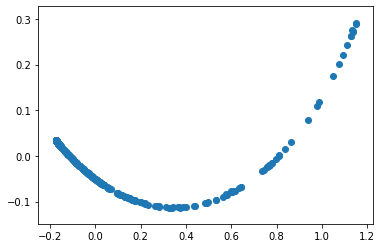

In [66]:
#visualize the pca components
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

Again, I will begin with MeanShift clustering.

In [67]:
#get bandwidth for model
bandwidth = estimate_bandwidth(X_norm, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 5


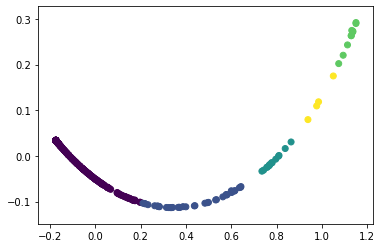

In [68]:
#plot the mean shift clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

In [69]:
#store cluster assignments in dataframe
pred = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(X_norm)
df['ms_cluster2'] = pred
for i in range(0, 5):
    print('Films in cluster ' + str(i) + ' :',len(df[df['ms_cluster2']== i]))

Films in cluster 0 : 401
Films in cluster 1 : 39
Films in cluster 2 : 14
Films in cluster 3 : 10
Films in cluster 4 : 4


The clusters appear to be the same as those that used the full set of variables.

In [70]:
df[df['ms_cluster2'] == 3]['title']

254                                             Star Wars
348                                          Forrest Gump
891                                          Citizen Kane
1164                                       Apocalypse Now
1884                                           Metropolis
2727                                      American Beauty
3765                                   Dancer in the Dark
6228                                         Finding Nemo
6383    Pirates of the Caribbean: The Curse of the Bla...
6715                                    Kill Bill: Vol. 1
Name: title, dtype: object

In [71]:
df[df['ms_cluster'] == 4]['title']

892                     2001: A Space Odyssey
1220                               Unforgiven
4085                            Amores perros
7192    Eternal Sunshine of the Spotless Mind
Name: title, dtype: object

Now, I will try K-Means and see whether the clusters from that are the same as when using the full set of variables.

In [72]:
# Declare and fit the model.
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X_norm)

# Extract cluster assignments for each data point.
labels = kmeans.labels_

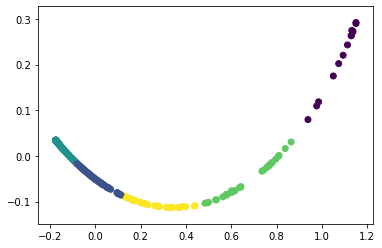

In [73]:
#plot k-means clusters visually
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

In [74]:
#store cluster assignments
pred = KMeans(n_clusters = 5).fit_predict(X_norm)
df['km5_cluster2'] = pred
for i in range(0, 5):
    print('Films in cluster ' + str(i) + ' :',len(df[df['km5_cluster2']== i]))

Films in cluster 0 : 44
Films in cluster 1 : 280
Films in cluster 2 : 14
Films in cluster 3 : 31
Films in cluster 4 : 99


The cluster distribution is different from the one that we got using the full set of variables. I will now try K-means with a larger k to see how that affects the distribution.

In [75]:
# Declare and fit the model.
kmeans = KMeans(n_clusters = 25)
kmeans.fit(X_norm)

# Extract cluster assignments for each data point.
labels = kmeans.labels_

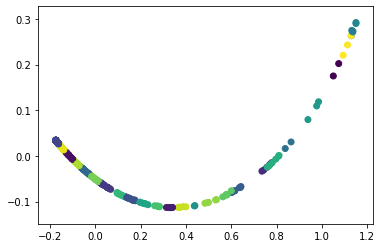

In [76]:
#plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

In [77]:
#store cluster assignments
pred = KMeans(n_clusters = 25).fit_predict(X_norm)
df['km25_cluster2'] = pred
for i in range(0, 25):
    print('Films in cluster ' + str(i) + ' :',len(df[df['km25_cluster2']== i]))

Films in cluster 0 : 20
Films in cluster 1 : 6
Films in cluster 2 : 226
Films in cluster 3 : 2
Films in cluster 4 : 8
Films in cluster 5 : 9
Films in cluster 6 : 14
Films in cluster 7 : 26
Films in cluster 8 : 4
Films in cluster 9 : 21
Films in cluster 10 : 2
Films in cluster 11 : 5
Films in cluster 12 : 13
Films in cluster 13 : 26
Films in cluster 14 : 23
Films in cluster 15 : 6
Films in cluster 16 : 4
Films in cluster 17 : 3
Films in cluster 18 : 6
Films in cluster 19 : 5
Films in cluster 20 : 21
Films in cluster 21 : 5
Films in cluster 22 : 9
Films in cluster 23 : 1
Films in cluster 24 : 3


Again, we have an issue where some clusters only contain 1 or 2 films. Let's take a closer look at some of the slightly larger clusters.

In [78]:
df[df['km25_cluster2'] == 13]['title']

423                                          Carlito's Way
873                                  It Happened One Night
879                                                Charade
910                                                  Laura
922                           Mr. Smith Goes to Washington
1154                                    The Princess Bride
1208                      The Treasure of the Sierra Madre
1216                                      The Great Escape
1232                                    Young Frankenstein
1584                                         Boogie Nights
1842                                    The Breakfast Club
2934             Women on the Verge of a Nervous Breakdown
2956                                       Bicycle Thieves
3064                                              Papillon
3324                                          Modern Times
3876                                             Cast Away
6828                                Hannah and Her Siste

In [79]:
df[df['km25_cluster2'] == 9]['title']

329            What's Eating Gilbert Grape
921                  It's a Wonderful Life
1153               The Empire Strikes Back
1166                    Return of the Jedi
1184                           Raging Bull
1202                         Touch of Evil
1225                  Fried Green Tomatoes
1533                     L.A. Confidential
1540                              The Game
2050                                  Rope
2181                      The Elephant Man
2601                          Barry Lyndon
3313          Guess Who's Coming to Dinner
3359                                Misery
6878                          Vivre Sa Vie
8203                             Tarnation
11120             The Pursuit of Happyness
11297                      Pan's Labyrinth
11467                      Freedom Writers
11561                          Ratatouille
12160    The Diving Bell and the Butterfly
Name: title, dtype: object

In [80]:
df[df['km25_cluster2'] == 0]['title']

290                                  Pulp Fiction
1009                                     Die Hard
1052                             Bonnie and Clyde
1161                           Lawrence of Arabia
1163                        To Kill a Mockingbird
1212                                  The Shining
1252                           The Killing Fields
1258                                 Paris, Texas
1336                                         Jaws
1401                                 Lost Highway
2437                                   The Matrix
3249                                          JFK
4751     Harry Potter and the Philosopher's Stone
5849                          Catch Me If You Can
5882                                  City of God
6618                        Judgment at Nuremberg
6980                                     Big Fish
7712     Harry Potter and the Prisoner of Azkaban
10541         Harry Potter and the Goblet of Fire
10846                         The Lives of Others


While some of the smaller clusters seem to give us fairly similar films, there are still some very large clusters that provide us with very little information about similar films.

To try to get more specific clusters, I will try taking a subset of the data and seeing whether the clusters for that reflect similar movies.

In [81]:
#select only romance movies
df_romance = df[df['Romance']== True]

In [82]:
#drop non-numeric variables and variables with transformed versions
X = df_romance.drop(['adult', 'budget', 'genres', 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 
             'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'spoken_languages',
            'status', 'title', 'video', 'vote_count', 'Music', 'Horror', 'Science Fiction', 'War', 'Foreign', 'Documentary',
             'Western', 'TV Movie', 'France', 'Germany', 'Italy', 'Canada', 'Japan', 'Spain', 'Russia', 'India', 
             'Hong Kong', 'Sweden', 'Australia', 'South Korea', 'Belgium', 'Metro-Goldwyn-Mayer (MGM)', 
             'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Universal Pictures', 
             'Columbia Pictures Corporation', 'Columbia Pictures', 'RKO Radio Pictures', 'Canal+', 'United Artists', 
             'New Line Cinema', 'Walt Disney Pictures', 'Touchstone Pictures', 'language_fr', 'language_ja', 'language_it',
             'language_de', 'language_es', 'language_ru', 'language_hi', 'language_ko', 'language_zh', 'John Ford', 
             'Michael Curtiz', 'Werner Herzog', 'Alfred Hitchcock', 'Georges Méliès', 'Woody Allen', 'Jean-Luc Godard',
             'Sidney Lumet', 'Charlie Chaplin', 'Raoul Walsh', 'Henry Hathaway', 'William A. Wellman', 'Martin Scorsese',
             'Richard Thorpe', 'woman director', 'independent film', 'murder', 'based on novel', 'musical', 'sex', 
             'violence', 'nudity', 'biography', 'revenge', 'suspense', 'love', 'female nudity', 'sport', 'police', 
             'teenager', 'duringcreditsstinger', 'sequel', 'friendship', 'ms_cluster', 'km5_cluster', 'Romance',
             'km10_cluster', 'ms_cluster', 'km25_cluster',
             'cast', 'crew', 'director', 'keywords'], axis = 1)
#normalize the data
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

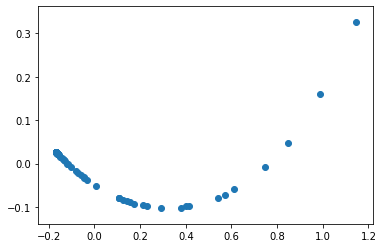

In [83]:
#visualize the pca components
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

I will try MeanShift first.

In [84]:
#get bandwidth for model
bandwidth = estimate_bandwidth(X_norm, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 7


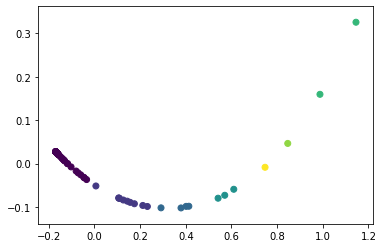

In [85]:
#plot the mean shift clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

In [86]:
#store cluster assignments in dataframe
pred = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(X_norm)
df_romance['ms_cluster'] = pred
for i in range(0, n_clusters_):
    print('Films in cluster ' + str(i) + ' :',len(df_romance[df_romance['ms_cluster']== i]))

Films in cluster 0 : 56
Films in cluster 1 : 10
Films in cluster 2 : 4
Films in cluster 3 : 3
Films in cluster 4 : 2
Films in cluster 5 : 1
Films in cluster 6 : 1


C:\Users\rkies\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Again, we have issues with some clusters being too small and some being too larger. The mid-sized clusters appear to yield some reasonable recommendations.

In [87]:
df_romance[df_romance['ms_cluster'] == 1]['title']

547                    True Romance
871                         Vertigo
877                   The Apartment
880                      Casablanca
888              Gone with the Wind
898                       Notorious
939           Cat on a Hot Tin Roof
1625                        Titanic
1813    The Best Years of Our Lives
4848               A Beautiful Mind
Name: title, dtype: object

In [88]:
df_romance[df_romance['ms_cluster'] == 2]['title']

870     Breakfast at Tiffany's
878           Some Like It Hot
2160       Edward Scissorhands
4827                    Amélie
Name: title, dtype: object

In [89]:
df_romance[df_romance['ms_cluster'] == 5]['title']

5739    Talk to Her
Name: title, dtype: object

In [90]:
df_romance[df_romance['ms_cluster'] == 6]['title']

210    Before Sunrise
Name: title, dtype: object

Next, I will try K-Means.

In [91]:
# Declare and fit the model.
kmeans = KMeans(n_clusters = 7)
kmeans.fit(X_norm)

# Extract cluster assignments for each data point.
labels = kmeans.labels_

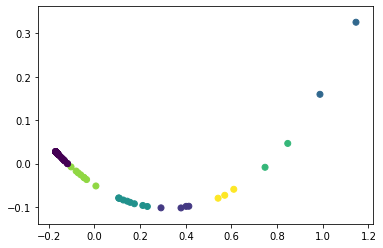

In [92]:
#plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

In [93]:
#store cluster assignments
pred = KMeans(n_clusters = 7).fit_predict(X_norm)
df_romance['km7_cluster'] = pred
for i in range(0, 7):
    print('Films in cluster ' + str(i) + ' :',len(df_romance[df_romance['km7_cluster']== i]))

Films in cluster 0 : 49
Films in cluster 1 : 4
Films in cluster 2 : 2
Films in cluster 3 : 9
Films in cluster 4 : 4
Films in cluster 5 : 1
Films in cluster 6 : 8


C:\Users\rkies\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


The KMeans clusters are a little bit more evenly distributed than the MeanShift clusters.

In [94]:
# Declare and fit the model.
kmeans = KMeans(n_clusters = 15)
kmeans.fit(X_norm)

# Extract cluster assignments for each data point.
labels = kmeans.labels_

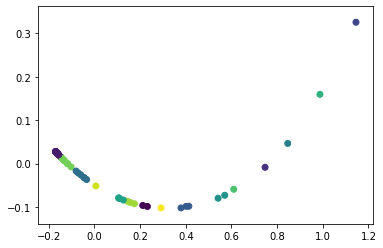

In [95]:
#plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

In [96]:
#store cluster assignments
pred = KMeans(n_clusters = 15).fit_predict(X_norm)
df_romance['km15_cluster'] = pred
for i in range(0, 15):
    print('Films in cluster ' + str(i) + ' :',len(df_romance[df_romance['km15_cluster']== i]))

Films in cluster 0 : 42
Films in cluster 1 : 1
Films in cluster 2 : 4
Films in cluster 3 : 1
Films in cluster 4 : 6
Films in cluster 5 : 3
Films in cluster 6 : 1
Films in cluster 7 : 1
Films in cluster 8 : 2
Films in cluster 9 : 1
Films in cluster 10 : 2
Films in cluster 11 : 8
Films in cluster 12 : 3
Films in cluster 13 : 1
Films in cluster 14 : 1


C:\Users\rkies\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In this case, adding more clusters to K-Means did not increase the amount of information we were able to get from the model. Next, I will try spectral clustering.

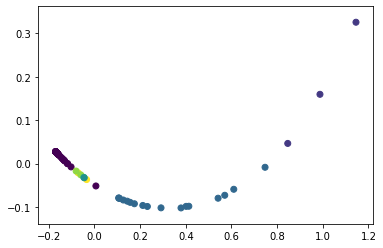

In [97]:
# Declare and fit the model.
sc = SpectralClustering(n_clusters=7)
sc.fit(X_norm)

# Extract cluster assignments for each data point.
labels = sc.labels_

#plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

In [98]:
#store cluster assignments
pred = SpectralClustering(n_clusters=7).fit_predict(X_norm)
df_romance['sc7_cluster'] = pred
for i in range(0, 7):
    print('Films in cluster ' + str(i) + ' :',len(df_romance[df_romance['sc7_cluster']== i]))

Films in cluster 0 : 51
Films in cluster 1 : 4
Films in cluster 2 : 1
Films in cluster 3 : 2
Films in cluster 4 : 16
Films in cluster 5 : 1
Films in cluster 6 : 2


C:\Users\rkies\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In this model, the clusters are either very small or very large.

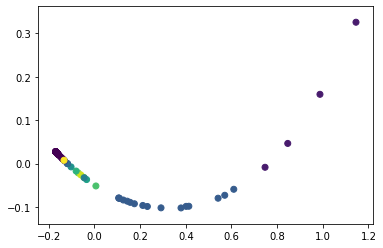

In [99]:
# Declare and fit the model.
sc = SpectralClustering(n_clusters=15)
sc.fit(X_norm)

# Extract cluster assignments for each data point.
labels = sc.labels_

#plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

In [100]:
#store cluster assignments
pred = SpectralClustering(n_clusters=15).fit_predict(X_norm)
df_romance['sc15_cluster'] = pred
for i in range(0, 15):
    print('Films in cluster ' + str(i) + ' :',len(df_romance[df_romance['sc15_cluster']== i]))

Films in cluster 0 : 45
Films in cluster 1 : 4
Films in cluster 2 : 16
Films in cluster 3 : 1
Films in cluster 4 : 1
Films in cluster 5 : 1
Films in cluster 6 : 1
Films in cluster 7 : 1
Films in cluster 8 : 1
Films in cluster 9 : 1
Films in cluster 10 : 1
Films in cluster 11 : 1
Films in cluster 12 : 1
Films in cluster 13 : 1
Films in cluster 14 : 1


C:\Users\rkies\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Adding more clusters did not give us more information about similar films. Next, I will try Affinity Propagation.

C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


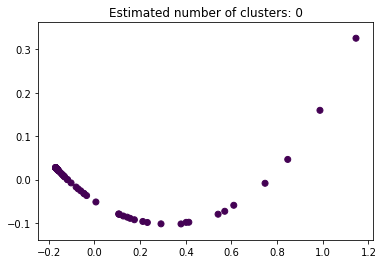

In [101]:
# Declare and fit the model.
af = AffinityPropagation()
af.fit(X_norm)

# Extract cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

#plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

Affinity Propagation did not find any cluster centers for this data.

Overall, I think that the best method for clustering movies for a movie recommendation system is to select a small subset of the data, in this case romance movies with vote averages above 7.5, and then use that data for clustering. When I used the 468 films with vote averages above 7.5, many of the clusters did not seem to have much in common. While much of the data was still bunched together with the romance-only subset, this was a much smaller group. MeanShift and K-Means both worked fairly well at clustering the romance movies. The advantage to MeanShift is that it automatically calculates the number of clusters, whereas K-Means takes some trial and error to find the optimal number of clusters.